## NSGA-II-LS algorithm

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.core.callback import Callback
from pymoo.optimize import minimize
import random
import copy
import seru
import generate

FileNotFoundError: [Errno 2] No such file or directory: './赛汝生产系统/算例测试/random_info.csv'

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       49 |      1 |             - |             -
     2 |       99 |      1 |  0.000000E+00 |             f
     3 |      149 |      1 |  0.000000E+00 |             f
     4 |      199 |      1 |  0.000000E+00 |             f
     5 |      249 |      1 |  0.000000E+00 |             f
     6 |      299 |      1 |  0.000000E+00 |             f
     7 |      349 |      1 |  0.000000E+00 |             f
     8 |      399 |      1 |  0.000000E+00 |             f
     9 |      449 |      1 |  7.0100000000 |         ideal
    10 |      499 |      1 |  0.000000E+00 |             f
    11 |      549 |      1 |  0.000000E+00 |             f
    12 |      599 |      1 |  0.000000E+00 |             f
    13 |      649 |      1 |  0.000000E+00 |             f
    14 |      699 |      1 |  0.000000E+00 |             f


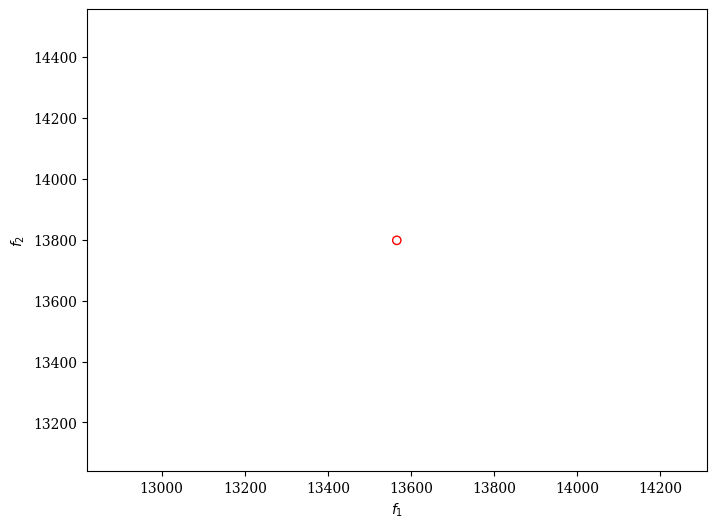

In [2]:
# 设置的数据组数
num = 100
alpha = 0.75

# generate.generate(num)
# 产品各道工序标准工时
time_info = pd.read_csv('./time_info.csv')
time_info = dict(zip(zip(time_info['产品类型'],time_info['工序']),time_info['标准工时']))
# 员工各技能熟练程度
skill_info = pd.read_csv('./skill_info.csv')
skill_info = skill_info.drop(columns=['员工'])
skill_info = skill_info.to_numpy()
# 产品切换时间
setup_time = pd.read_csv('./setup_time.csv')
setup_time = dict(zip(setup_time['类型'],setup_time['时间']))
W,L = skill_info.shape  # 工人数和工序数
N = int(len(time_info)/L)  # 产品类型数
random_info = pd.read_csv('./random_info.csv')
M = len(random_info)  # 批次数

def gen_chrom():
    x = np.array([],dtype=int)
    sequence1 = np.random.permutation(list(range(1,2*W)))
    x=sequence1
    return x

def get_duration(x,batch_info,batch_list):
    """染色体评价函数"""
    # 染色体解码
    formation = [i if i <= W else 0 for i in x]
    # 使用列表切片根据 0 切割成多个子列表
    formation = [formation[i:j] for i, j in zip([0] + [idx + 1 for idx, val in enumerate(formation) if val == 0],
    [idx for idx, val in enumerate(formation) if val == 0] + [None])]
    # 删除多余空列表
    formation = [sublist for sublist in formation if sublist]
    J = len(formation)  # 赛汝个数
    seru_list = [seru.Seru() for _ in range(J)]  # 赛汝列表
    staff_list = [seru.Staff(i) for i in range(1,W+1)]
    # 赛汝内加入工人
    for i,sub in enumerate(formation):
        for j,subsub in enumerate(sub):
            seru_list[i].add_staff(staff_list[subsub-1])
            
    # 赛汝内加入产品批次
    scheduling = list(range(1,M+1))
    seru_time = [0]*J  # 记录各个赛汝的加工时间
    for i in scheduling:
        assign_seru = np.argmin(seru_time)
        seru_list[assign_seru].add_batch(batch_list[i-1],time_info,skill_info,L,setup_time)
        # 更新工时列表
        for j in range(J):
            seru_time[j] = seru_list[j].process_time

    return max(seru_time)

def calculate_cvar(data, alpha):
    sorted_data = np.sort(data)
    n = len(sorted_data)
    var_index = int(np.floor(alpha * n))
    cvar = np.round(np.mean(sorted_data[var_index:]),2)
    return cvar
def evaluate(x,num):
    ans = []
    for i in range(num):
        file_name = './数据/batch_info'+str(i+1)+'.csv'
        batch_info = pd.read_csv(file_name)
        batch_list = [seru.Batch(row['批次'], row['批量大小'], row['类型']) for _, row in batch_info.iterrows()]
        a = get_duration(x,batch_info,batch_list)
        ans.append(a)
    ans = np.array(ans)
    mean = round(ans.mean(),2)
    cvar = calculate_cvar(ans,alpha)
    return mean,cvar

def decode(x):
    # 染色体解码
    formation = [i if i <= W else 0 for i in x] 
    # 使用列表切片根据 0 切割成多个子列表
    formation = [formation[i:j] for i, j in zip([0] + [idx + 1 for idx, val in enumerate(formation) if val == 0],
    [idx for idx, val in enumerate(formation) if val == 0] + [None])]
    # 删除多余空列表
    formation = [sublist for sublist in formation if sublist]
    return formation

def encode(solution):
    chrom = []
    for i,sub_list in enumerate(solution):
        chrom = chrom + sub_list + [W+1+i]
    chrom = chrom + list(range(len(chrom)+1,2*W))
    return chrom

class Myproblem(ElementwiseProblem):
    
    def __init__(self,W,M,**kwargs):
        self.W = W
        self.M = M
        chrom = [0]*(2*W-1)
        super().__init__(vars = chrom,n_obj=2,xl=1,xu=2*W-1,**kwargs)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1,f2 = evaluate(x,num)
        out['F'] = [f1,f2]
        
class Mysampling(Sampling):
    
    def _do(self,problem,n_samples,**kwargs):
        X = np.full((n_samples,2*W-1),0,dtype=int)
        for i in range(n_samples):
            X[i,:] = gen_chrom()
        X[0,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[1,:] = encode([[17, 14, 9, 10, 2, 7, 18, 16, 6, 5, 13], [3, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[2,:] = encode([[3, 5, 2, 7, 18, 13, 15, 16, 1, 17, 6], [14, 19, 10, 20, 9, 11, 8, 12, 4]])
        X[3,:] = encode([[3, 5, 2, 7, 18, 16, 6, 17, 9, 13, 15], [11, 19, 14, 1, 20, 12, 8, 4, 10]])
        X[4,:] = encode([[17, 9, 2, 7, 18, 16, 6, 1, 5, 13, 19], [11, 8, 14, 10, 20, 15, 12, 3, 4]])
        X[5,:] = encode([[9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 17, 3]])
        X[6,:] = encode([[3, 9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 20, 8, 12, 17, 4]])
        X[7,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[8,:] = encode([[17, 3, 9, 4, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 2]])
        X[9,:] = encode([[17, 9, 2, 6, 10, 18, 16, 7, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 3]])
        X[10,:] = encode([[3, 5, 2, 7, 9, 17, 18, 16, 4, 19, 13], [6, 11, 14, 1, 20, 12, 8, 10, 15]])
        X[11,:] = encode([[9, 2, 7, 4, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 17, 3]])
        return X

def order_crossover(p1,p2,point_1,point_2):
    """顺序交叉。将父代染色体1该区域内的基因复制到子代1相同位置上，再在父代染色体2上将子代1中缺少的基因按照顺序填入。

    Args:
        p1 (_type_): 父代1
        p2 (_type_): 父代2
        point_1 (_type_): 交叉点1
        point_2 (_type_): 交叉点2
    """
    p1_seg = p1[point_1:point_2]
    p2_seg = p2[point_1:point_2]
    off1_seg,off2_seg = [],[]  # 子代的片段
    
    off1_seg = [i for i in p2 if i in p1_seg]  # 子代1的片段
    off2_seg = [i for i in p1 if i in p2_seg]  # 子代2的片段
    
    off1,off2 = copy.deepcopy(p1),copy.deepcopy(p2)  # 子代个体
    for i in range(point_1,point_2):
        off1[i] = off1_seg[i-point_1]
        off2[i] = off2_seg[i-point_1]
    return off1,off2

class MyCrossover(Crossover):
    def __init__(self):
        super().__init__(2,2)
    
    def _do(self,problem,X,**kwargs):
        _,n_matings,n_var = X.shape
        Y = np.full_like(X,0,dtype=int)
        for k in range(n_matings):
            a,b = X[0,k,:],X[1,k,:]
            # 构造部分
            point_1 = random.randint(0,2*W-2)
            point_2 = random.randint(0,2*W-2)
            point_min = min(point_1,point_2)
            point_max = max(point_1,point_2)
            off_a,off_b = copy.deepcopy(order_crossover(a,b,point_min,point_max))
            Y[0, k, :], Y[1, k, :] = off_a, off_b
        return Y

class MyMutation(Mutation):
    def __init__(self):
        super().__init__()
    
    def _do(self,problem,X,**kwargs):
        for i in range(len(X)):
            r = np.random.random()
            if r < 0.5:
                m11 = random.randint(0,2*W-2)
                m12 = random.randint(0,2*W-2)
                m11,m12 = min(m11,m12),max(m11,m12)
                p = X[i,:]
                p[m11],p[m12] = p[m12],p[m11]
                X[i,:] = p
        return X
    
from pymoo.core.callback import Callback

# 定义自定义邻域搜索操作
class MyNeighborhoodSearch:
    def __init__(self):
        pass
    
    def search(self, problem, x):
        # 执行邻域搜索操作
        loc = random.randint(1,2*W-2)
        x_new = np.concatenate((x[loc:], x[:loc]))
        return x_new

#重写我的callback
class MyCallback(Callback):
    def __init__(self,search) -> None:
        super().__init__()
        self.search = search
        self.best_individual = None

    def notify(self, algorithm):
        pop = algorithm.pop
        # 第一代，随机选择一个个体作为初始最优个体
        if self.best_individual is None:
            self.best_individual = pop[0].X
        # 找到当前代的最优个体
        best_index = np.argmin(pop.get("F")[:, 0])  # 这里以第一个目标函数为例
        best_individual = pop[best_index].X
        # 如果最优个体发生变化，则进行邻域搜索操作
        if not np.array_equal(self.best_individual, best_individual):
            self.best_individual = best_individual
            problem = algorithm.problem
            x_new = self.search.search(problem, best_individual)
            best_individual = x_new

            # 更新当前最优个体
            pop[best_index].X = best_individual

class MyDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        a = decode(a.X)
        b = decode(b.X)
        for i in a:
            i = i.sort()
        for i in b:
            i = i.sort()
        # 定义自定义的排序函数，按照子列表的第一个元素进行排序
        def sort_by_first_element(lst):
            return sorted(lst, key=lambda x: x[0])
        a = sort_by_first_element(a)
        b = sort_by_first_element(b)
        return a == b

m = Myproblem(W=W,M=M)
algorithm = NSGA2(
    pop_size=50,
    sampling=Mysampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
    eliminate_duplicates=MyDuplicateElimination()
    )
search = MyNeighborhoodSearch()

from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
termination = get_termination("time", "00:00:60")
res = minimize(
        m,
        algorithm,
        termination=termination,
        verbose=True,
        save_history=False,
        callback = MyCallback(search),
        )

plot = Scatter()
plot.add(m.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

# ----------------输出所有的构造方案---------
# schemes = [] 
# for i in range(len(res.X)):
#     schemes.append(decode(res.X[i]))
# print(schemes)

In [ ]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A = res.F
for i in range(A.shape[1]):
    A[:, i] = A[:, i] / np.max(A[:, i])
# print(A)
# ref_point = np.max(A, axis=0)
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)
print("HV", ind(A))
spacing = SpacingIndicator()
spacing = spacing._do(A)
print('spacing',spacing)
ans = {}
ans['NSGA2-LS的HV'] = ind(A)
ans['NSGA2-LS的spacing'] = spacing

HV 2.695630687209417e-07
spacing 0.00026780036756934335


## NSGA-II algorithm

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       49 |      1 |             - |             -
     2 |       99 |      1 |  0.000000E+00 |             f
     3 |      149 |      2 |  1.0000000000 |         ideal
     4 |      199 |      3 |  0.2310011665 |             f
     5 |      249 |      3 |  0.000000E+00 |             f
     6 |      299 |      3 |  0.000000E+00 |             f
     7 |      349 |      3 |  0.000000E+00 |             f
     8 |      399 |      3 |  0.000000E+00 |             f
     9 |      449 |      3 |  0.000000E+00 |             f
    10 |      499 |      4 |  0.0714285714 |         ideal
    11 |      549 |      4 |  0.000000E+00 |             f
    12 |      599 |      4 |  0.000000E+00 |             f
    13 |      649 |      4 |  0.000000E+00 |             f
    14 |      699 |      2 |  0.6621983914 |         ideal


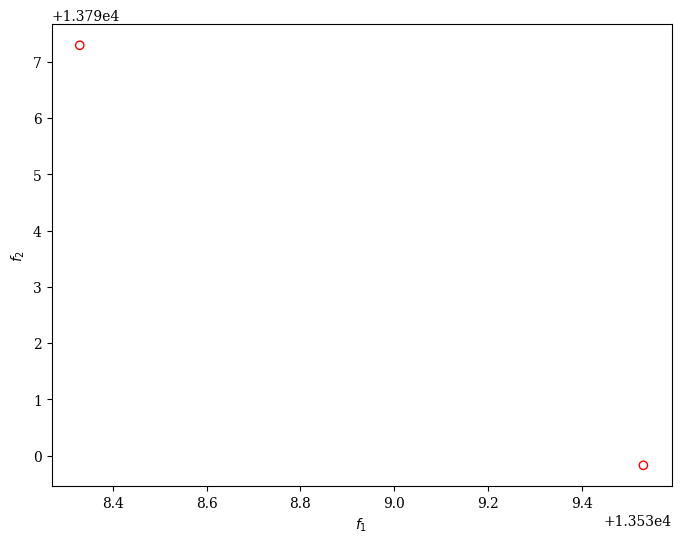

In [ ]:

class Mysampling(Sampling):
    
    def _do(self,problem,n_samples,**kwargs):
        X = np.full((n_samples,2*W-1),0,dtype=int)
        for i in range(n_samples):
            X[i,:] = gen_chrom()
        X[0,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[1,:] = encode([[17, 14, 9, 10, 2, 7, 18, 16, 6, 5, 13], [3, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[2,:] = encode([[3, 5, 2, 7, 18, 13, 15, 16, 1, 17, 6], [14, 19, 10, 20, 9, 11, 8, 12, 4]])
        X[3,:] = encode([[3, 5, 2, 7, 18, 16, 6, 17, 9, 13, 15], [11, 19, 14, 1, 20, 12, 8, 4, 10]])
        X[4,:] = encode([[17, 9, 2, 7, 18, 16, 6, 1, 5, 13, 19], [11, 8, 14, 10, 20, 15, 12, 3, 4]])
        X[5,:] = encode([[9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 17, 3]])
        X[6,:] = encode([[3, 9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 20, 8, 12, 17, 4]])
        X[7,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[8,:] = encode([[17, 3, 9, 4, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 2]])
        X[9,:] = encode([[17, 9, 2, 6, 10, 18, 16, 7, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 3]])
        X[10,:] = encode([[3, 5, 2, 7, 9, 17, 18, 16, 4, 19, 13], [6, 11, 14, 1, 20, 12, 8, 10, 15]])
        X[11,:] = encode([[9, 2, 7, 4, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 17, 3]])
        return X

m = Myproblem(W=W,M=M)
algorithm = NSGA2(
    pop_size=50,
    sampling=Mysampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
    eliminate_duplicates=MyDuplicateElimination()
    )

from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
termination = get_termination("time", "00:00:60")
res1 = minimize(
        m,
        algorithm,
        termination=termination,
        verbose=True,
        save_history=False
        )

plot = Scatter()
plot.add(m.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res1.F, facecolor="none", edgecolor="red")
plot.show()

# ----------------输出所有的构造方案---------
# schemes = [] 
# for i in range(len(res.X)):
#     schemes.append(decode(res.X[i]))
# print(schemes)

In [ ]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
A1 = res1.F
for i in range(A1.shape[1]):
    A1[:, i] = A1[:, i] / np.max(A1[:, i])
# print(A)
# ref_point = np.max(A1, axis=0)
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)
print("HV", ind(A1))
spacing = SpacingIndicator()
spacing = spacing._do(A1)
print('spacing',spacing)
ans['NSGA2的HV'] = ind(A1)
ans['NSGA2的spacing'] = spacing

HV 0.0
spacing 0.0


## CTAEA algorithm

c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
c:\Users\27249\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, cas

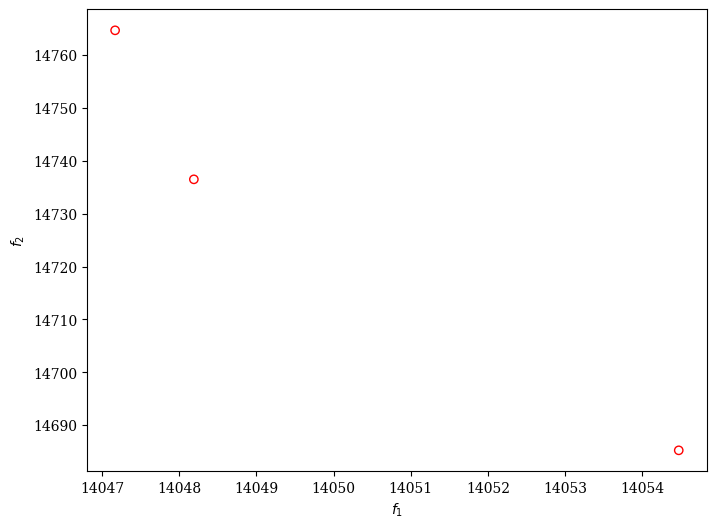

In [ ]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Mysampling(Sampling):
    
    def _do(self,problem,n_samples,**kwargs):
        X = np.full((n_samples,2*W-1),0,dtype=int)
        for i in range(n_samples):
            X[i,:] = gen_chrom()
        X[0,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[1,:] = encode([[17, 14, 9, 10, 2, 7, 18, 16, 6, 5, 13], [3, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[2,:] = encode([[3, 5, 2, 7, 18, 13, 15, 16, 1, 17, 6], [14, 19, 10, 20, 9, 11, 8, 12, 4]])
        X[3,:] = encode([[3, 5, 2, 7, 18, 16, 6, 17, 9, 13, 15], [11, 19, 14, 1, 20, 12, 8, 4, 10]])
        X[4,:] = encode([[17, 9, 2, 7, 18, 16, 6, 1, 5, 13, 19], [11, 8, 14, 10, 20, 15, 12, 3, 4]])
        X[5,:] = encode([[9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 17, 3]])
        X[6,:] = encode([[3, 9, 2, 7, 10, 18, 16, 6, 5, 19, 13], [14, 1, 15, 11, 20, 8, 12, 17, 4]])
        X[7,:] = encode([[17, 3, 9, 2, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 12, 15, 20, 8, 4]])
        X[8,:] = encode([[17, 3, 9, 4, 7, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 2]])
        X[9,:] = encode([[17, 9, 2, 6, 10, 18, 16, 7, 5, 19, 13], [14, 1, 15, 11, 4, 20, 8, 12, 3]])
        X[10,:] = encode([[3, 5, 2, 7, 9, 17, 18, 16, 4, 19, 13], [6, 11, 14, 1, 20, 12, 8, 10, 15]])
        X[11,:] = encode([[9, 2, 7, 4, 10, 18, 16, 6, 5, 13], [14, 19, 1, 11, 15, 20, 8, 12, 17, 3]])
        return X
m = Myproblem(W=W,M=M)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=4)
class Mysampling(Sampling):
    
    def _do(self,problem,n_samples,**kwargs):
        X = np.full((n_samples,2*W-1),0,dtype=int)
        for i in range(n_samples):
            X[i,:] = gen_chrom()
        return X

from pymoo.termination import get_termination
termination = get_termination("time", "00:00:60")
# create the algorithm object
algorithm = CTAEA(ref_dirs=ref_dirs,
                  sampling=Mysampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  eliminate_duplicates=MyDuplicateElimination()
                  )

# execute the optimization
res2 = minimize(m,
               algorithm,
               termination=termination,
               verbose=False,
               )
plot = Scatter()
plot.add(m.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res2.F, facecolor="none", edgecolor="red")
plot.show()

In [ ]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
res2.F = np.concatenate((res.F[:4], res2.F), axis=0)
A2 = res2.F
for i in range(A2.shape[1]):
    A2[:, i] = A2[:, i] / np.max(A2[:, i])
# print(A)
# ref_point = np.max(A, axis=0)
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)
print("HV", ind(A2))
spacing = SpacingIndicator()
spacing = spacing._do(A2)
print('spacing',spacing)
ans['CTAEA的HV'] = ind(A2)
ans['CTAEA的spacing'] = spacing

HV 0.9998612124728375
spacing 0.0014302408117106062


## MOEA/D algorithm

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        7 |      2 |             - |             -
     2 |       14 |      2 |  0.000000E+00 |             f
     3 |       21 |      7 |  0.6866068022 |         ideal
     4 |       28 |      7 |  0.7028452305 |         ideal
     5 |       35 |      7 |  0.000000E+00 |             f
     6 |       42 |      7 |  3.472360E+03 |         ideal
     7 |       49 |      7 |  9.787700E+02 |         ideal
     8 |       56 |      7 |  1.0000000000 |         ideal
     9 |       63 |      7 |  0.0701317088 |         ideal
    10 |       70 |      7 |  1.268710E+03 |         ideal
    11 |       77 |      7 |  0.000000E+00 |             f
    12 |       84 |      7 |  0.000000E+00 |             f
    13 |       91 |      7 |  1.165200E+02 |         ideal
    14 |       98 |      7 |  0.000000E+00 |             f
    15 |      105 |      7 |  0.000000E+00 |             f
    16 |      112 |      7 |  0.000000E+00 |            

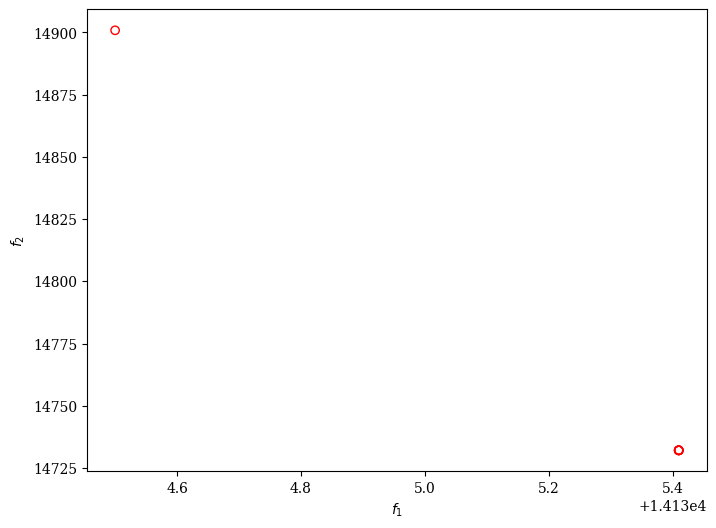

In [ ]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions

class Mysampling(Sampling):
    
    def _do(self,problem,n_samples,**kwargs):
        X = np.full((n_samples,2*W-1),0,dtype=int)
        for i in range(n_samples):
            X[i,:] = gen_chrom()
        return X
m = Myproblem(W=W,M=M)
ref_dirs = get_reference_directions("uniform", 2, n_partitions=6)

algorithm = MOEAD(
    ref_dirs,
    sampling=Mysampling(),
    crossover=MyCrossover(),
    mutation=MyMutation(),
)
from pymoo.termination import get_termination
termination = get_termination("time", "00:00:60")
res3 = minimize(m,
               algorithm,
               termination=termination,
               verbose=True)

plot = Scatter()
plot.add(m.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res3.F, facecolor="none", edgecolor="red")
plot.show()

In [ ]:
from pymoo.indicators.hv import HV
from pymoo.indicators.spacing import SpacingIndicator
# res3.F = np.concatenate((res.F[:4], res3.F), axis=0)
A3 = res3.F
for i in range(A3.shape[1]):
    A3[:, i] = A3[:, i] / np.max(A3[:, i])
# print(A)
# ref_point = np.max(A, axis=0)
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)
print("HV", ind(A3))
spacing = SpacingIndicator()
spacing = spacing._do(A3)
print('spacing',spacing)
ans['MOEA/D的HV'] = ind(A3)
ans['MOEA/D的spacing'] = spacing

HV 0.0
spacing 0.003986570782906483


In [ ]:
from pymoo.indicators.gd import GD

ind = GD(A)
ans['NSGA2-LS的SP'] = ind(A)
ans['NSGA2的SP'] = ind(A1)
ans['CTAEA的SP'] = ind(A2)
ans['MOEA/D的SP'] = ind(A3)
ans

{'NSGA2-LS的HV': 2.695630687209417e-07,
 'NSGA2-LS的spacing': 0.00026780036756934335,
 'NSGA2的HV': 0.0,
 'NSGA2的spacing': 0.0,
 'CTAEA的HV': 0.9998612124728375,
 'CTAEA的spacing': 0.0014302408117106062,
 'MOEA/D的HV': 0.0,
 'MOEA/D的spacing': 0.003986570782906483,
 'NSGA2-LS的SP': 0.0,
 'NSGA2的SP': 0.00027459724786190967,
 'CTAEA的SP': 0.8085948926405652,
 'MOEA/D的SP': 0.00938385149385727}

In [ ]:
9.27325700977519E-08*(random.random())

5.970152055532723e-08

In [ ]:
1.21 , 1.92 , 1.68
1.85 , 1.42 , 1.74
1.45 , 1.62 , 1.23
1.55 , 1.72 , 1.98
1.94 , 1.12 , 1.55
1.59 , 1.23 , 1.41
1.12 , 1.76 , 1.28
1.42 , 1.58 , 1.97
1.76 , 1.29 , 1.93
1.58 , 1.92 , 1.33
1.12 , 1.67 , 1.45
1.29 , 1.93 , 1.42
1.73 , 1.29 , 1.64
1.81 , 1.53 , 1.69